In [1]:
from netCDF4 import Dataset
#import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [5]:
grid = Dataset("rotating-ellipse-20x8x20.fci.nc", "r")

MXG = int(grid.variables["MXG"].getValue())
n_total = int(grid.variables["total_cells"].getValue()) # Number of cells, including boundary cells
cell_number = grid.variables["cell_number"][:]
cell_number_forward = grid.variables["forward_cell_number"][:]
cell_number_backward = grid.variables["backward_cell_number"][:]

forward = {'ncells': n_total,
           'weights': grid.variables["forward_weights"][:],
           'rows': grid.variables["forward_rows"][:],
           'columns': grid.variables["forward_columns"][:]}

backward = {'ncells': n_total,
           'weights': grid.variables["backward_weights"][:],
           'rows': grid.variables["backward_rows"][:],
           'columns': grid.variables["backward_columns"][:]}

#J = grid.variables["J"][:]
#dx = grid.variables["dx"][:]
#dx = grid.variables["dx"][:]
#dz = grid.variables["dz"][:]
#dV = J * dx * dy * dz

grid.close()

n_evolving = len(forward['rows'])    # Number of time-evolving cells

In [6]:
volume = tf.ones(n_total, dtype=tf.dtypes.float64)  # Volume of each cell, including boundary cells

NameError: name 'tf' is not defined

# Boundary conditions



In [4]:
nx, ny, nz = cell_number.shape

# Iterate over inner boundary
boundary_xinner = []
for i in range(MXG):
    for j in range(ny):
        for k in range(nz):
            # Pair of indices: First is the boundary, second is the point inside the domain
            boundary_xinner.append([cell_number[i, j, k], cell_number[MXG, j, k]])

# Outer boundary
boundary_xouter = []
for i in range(nx - MXG, nx):
    for j in range(ny):
        for k in range(nz):
            # Pair of indices: First is the boundary, second is the point inside the domain
            boundary_xouter.append([cell_number[i, j, k], cell_number[nx - MXG - 1, j, k]])

# Yforward
boundary_yforward = []
for i in range(MXG, nx - MXG):
    for j in range(ny):
        for k in range(nz):
            if cell_number_forward[i, j, k] > 0:
                boundary_yforward.append([cell_number_forward[i, j, k], cell_number[i, j, k]])

# Ybackward
boundary_ybackward = []
for i in range(MXG, nx - MXG):
    for j in range(ny):
        for k in range(nz):
            if cell_number_backward[i, j, k] > 0:
                boundary_ybackward.append([cell_number_backward[i, j, k], cell_number[i, j, k]])

print(f"Boundary points xinner {len(boundary_xinner)}, xouter {len(boundary_xouter)}, yforward {len(boundary_yforward)}, ybackward {len(boundary_ybackward)}")
n_boundary = len(boundary_xinner) + len(boundary_xouter) + len(boundary_yforward) + len(boundary_ybackward)

print(f"Cells: n_evolving {n_evolving} n_boundary {n_boundary} total {n_evolving + n_boundary} (check: {n_total})")

Boundary points xinner 320, xouter 320, yforward 607, ybackward 604
Cells: n_evolving 2560 n_boundary 1851 total 4411 (check: 4411)


In [5]:
boundary_xinner = tf.constant(boundary_xinner, dtype=tf.int64)
boundary_xouter = tf.constant(boundary_xouter, dtype=tf.int64)

boundary_yforward = tf.constant(boundary_yforward, dtype=tf.int64)
boundary_ybackward = tf.constant(boundary_ybackward, dtype=tf.int64)

In [35]:
# Operator to add boundary rows. This is a non-square matrix [n_total, n_evolving]

add_boundaries_op = tf.sparse.eye(n_total, num_columns = n_evolving, dtype=tf.dtypes.float64)

add_dirichlet_boundaries_op = tf.sparse.reorder(tf.sparse.SparseTensor(
    tf.concat([add_boundaries_op.indices,
               boundary_xinner,
               boundary_xouter,
               boundary_yforward,
               boundary_ybackward], axis=0),
    tf.concat([add_boundaries_op.values,
               tf.ones(n_boundary, dtype=tf.dtypes.float64) * -1], axis=0),
    add_boundaries_op.dense_shape))
               
add_neumann_boundaries_op = tf.sparse.reorder(tf.sparse.SparseTensor(
    tf.concat([add_boundaries_op.indices,
               boundary_xinner,
               boundary_xouter,
               boundary_yforward,
               boundary_ybackward], axis=0),
    tf.concat([add_boundaries_op.values,
               tf.ones(n_boundary, dtype=tf.dtypes.float64)], axis=0),
    add_boundaries_op.dense_shape))

In [36]:
# Operator to discard boundary rows

discard_boundaries = tf.sparse.eye(n_evolving, num_columns=n_total, dtype=tf.dtypes.float64)

# Forward and backward interpolation operators

In [37]:
def create_operator(csr):
    """
    csr has keys "ncells", "weights", "rows" and "columns"

    https://www.tensorflow.org/guide/sparse_tensor

    # Returns
    
    A tf.sparse.SparseTensor that is non-square [n_evolving, n_total]
     - Number of rows is the number of evolving cells
     - Number of columns is the total number of cells (evolving + boundary)
    """
    ncells = csr['ncells']
    rows = csr['rows']
    columns = csr['columns']
    weights = csr['weights']
    
    indices = []
    values = []
    dense_shape = [len(rows), ncells]

    for i in range(len(rows)):
        # Get the range of indices into the weights and columns arrays
        jstart = rows[i]
        if i == len(rows) - 1:
            jend = len(weights)
        else:
            jend = rows[i+1]
        for j in range(jstart, jend):
            indices.append([i, columns[j]])
            values.append(weights[j])

    return tf.sparse.SparseTensor(indices=tf.constant(indices, dtype=tf.int64),
                                  values=values,
                                  dense_shape=dense_shape)
    

In [23]:
forward_op = create_operator(forward)
backward_op = create_operator(backward)

# Parallel gradient operator

The gradient operator is a matrix $G$ such that the value of the gradient in cell $i$ of a field $f$ is 
$$
    \left(\nabla f\right)_i = \sum_j G_{ij} f_j
$$

- Points inside the domain are calculated using central differences: forward - backward
- Parallel boundary points calculated using one-sided differences
- Radial boundaries not modified



In [24]:
# Scaling a sparse tensor is a sonewhat convoluted process
minus_backward_op = tf.sparse.SparseTensor(backward_op.indices,
                                            tf.negative(backward_op.values), # Negate values
                                            backward_op.dense_shape)

In [25]:
# Operator with n_evolving rows
grad_par_op = tf.sparse.add(forward_op,
                             minus_backward_op)

#tf.sparse.to_dense(tf.sparse.reorder(backward_op))

# Add rows for the radial (X) and parallel (Y) boundaries
# to create a square n_total x n_total matrix
grad_par_op = tf.sparse.SparseTensor(tf.concat([grad_par_op.indices,
                                                # X boundaries unchanged - ones on the diagonal
                                                tf.tile(boundary_xinner[:, 0][...,tf.newaxis], multiples=[1,2]),
                                                tf.tile(boundary_xouter[:, 0][...,tf.newaxis], multiples=[1,2]),
                                                # Y forward boundaries one-sided differences
                                                tf.tile(boundary_yforward[:, 0][...,tf.newaxis], multiples=[1,2]),
                                                boundary_yforward,
                                                # Y backward boundaries
                                                tf.tile(boundary_ybackward[:, 0][...,tf.newaxis], multiples=[1,2]),
                                                boundary_ybackward,
                                               ], axis = 0),
                                     tf.concat([grad_par_op.values,
                                                # X boundaries unchanged - ones on the diagonal
                                                tf.ones( boundary_xinner.shape[0] + boundary_xouter.shape[0], dtype=tf.dtypes.float64 ),
                                                # Y forward boundaries
                                                tf.ones( boundary_yforward.shape[0], dtype=tf.dtypes.float64 ),    # +1 in forward boundary cell
                                                tf.negative(tf.ones( boundary_yforward.shape[0], dtype=tf.dtypes.float64 )), # -1 in center cell
                                                # Y backward boundaries
                                                tf.negative(tf.ones( boundary_ybackward.shape[0], dtype=tf.dtypes.float64 )),  # -1 in boundary cell
                                                tf.ones( boundary_ybackward.shape[0], dtype=tf.dtypes.float64 ) # +1 in center cell
                                               ], axis = 0),
                                     [n_total, n_total])
grad_par_op = tf.sparse.reorder(grad_par_op) # Correctly sort indices

# Parallel divergence operator

Using Support Operator Method (SOM). The gradient operator is a matrix $G$ such that the value of the gradient in cell $i$ of a field $f$ is 

$$
    \left(\nabla f\right)_i = \sum_j G_{ij} f_j
$$

Use the integral form of Gauss' law, the divergence and gradient operators are related by:

$$
    \int f \nabla \cdot\mathbf{v} dV + \int \left(\nabla f\right)\cdot \mathbf{v} dV = \oint f \mathbf{v}\cdot d\mathbf{S}
$$

In discrete form:

$$
    \sum_i f_i \left(\nabla\cdot\mathbf{v}\right)_i W_i + \sum_i \left(\nabla f\right)_i v_i W_i = B.C
$$

Substitute, set B.C to zero flux:

$$
    \sum_i f_i \left(\nabla\cdot\mathbf{v}\right)_i W_i + \sum_i \sum_j G_{ij} f_j v_i W_i = 0
$$

Swap the $i$ and $j$ indices, rearrange:

$$
    \sum_i f_i \left(\nabla\cdot\mathbf{v}\right)_i W_i + \sum_i f_j \sum_j G_{ji} v_j W_j = 0
$$

To be valid for any $f_i$, this must be true for each $i$:

$$
    \left(\nabla\cdot\mathbf{v}\right)_i = D_{ij} v_j = - \frac{W_j}{W_i}G_{ji} v_j
$$

In [38]:
div_par_op = tf.sparse.SparseTensor(tf.roll(grad_par_op.indices, shift=1, axis=1), # Transpose
                                    (grad_par_op.values * 
                                     tf.gather(1/volume, grad_par_op.indices[:,1]) * 
                                     tf.gather(volume, grad_par_op.indices[:,0])), # Scale wiith W_j / W_i
                                    grad_par_op.dense_shape)
div_par_op = tf.sparse.reorder(div_par_op)

In [62]:
f = tf.random.uniform([n_evolving], minval = 0, maxval = 1, dtype=tf.dtypes.float64)
v = tf.random.uniform([n_evolving], minval = 0, maxval = 1, dtype=tf.dtypes.float64)

tf.sparse.sparse_dense_matmul(
                    discard_boundaries,
                    tf.sparse.sparse_dense_matmul(
                        grad_par_op,
                        tf.sparse.sparse_dense_matmul(
                            add_neumann_boundaries_op,
                            f))),

2025-06-03 12:12:58.856901: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Tensor 'b' is not a matrix


InvalidArgumentError: {{function_node __wrapped__SparseTensorDenseMatMul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Tensor 'b' is not a matrix [Op:SparseTensorDenseMatMul] name: 

# Time integration of parallel wave equations

Evolution of fields $f$ and $v$
$$
\frac{\partial v}{\partial t} = - \partial_{||} f
$$
$$
\frac{\partial f}{\partial t} = - \nabla_{||} v
$$

Integrate in time with a backward Euler method

$$
\left(I - dt J\right)f_{t+1} = f_{t} 
$$

$$
\begin{bmatrix}
I & dt\partial_{||} \\
dt \nabla_{||} & I \end{bmatrix}\begin{bmatrix}
v_{t+1} \\
f_{t+1}\end{bmatrix} = \begin{bmatrix}
v_{t} \\
f_{t}\end{bmatrix}
$$

## Boundary conditions

Setting Neumann boundary condition on $f$, Dirichlet on $v$

In [45]:
dt = 0.1
lhs = tf.concat([
            # v equation
            tf.concat([
                tf.eye(n_evolving, dtype=tf.dtypes.float64), 
                # Set Dirichlet boundaries; Take gradient; Discard boundaries
                tf.sparse.sparse_dense_matmul(
                    discard_boundaries,
                    tf.sparse.sparse_dense_matmul(
                        tf.sparse.to_dense(grad_par_op * dt),
                        add_dirichlet_boundaries_op))
            ], axis=1),
            # f equation
            tf.concat([
                tf.sparse.sparse_dense_matmul(
                    discard_boundaries,
                    tf.sparse.sparse_dense_matmul(
                        tf.sparse.to_dense(div_par_op * dt),
                        add_neumann_boundaries_op)),
                tf.eye(n_evolving, dtype=tf.dtypes.float64)], axis=1)
], axis=0)

In [46]:
# LU decomposition

lu, p = tf.linalg.lu(lhs)

In [47]:
state = tf.random.uniform([2 * n_evolving], minval = 0, maxval = 1, dtype=tf.dtypes.float64)
state = state[...,tf.newaxis]

Range: -53.78351977706652 -> 78.97158352285574


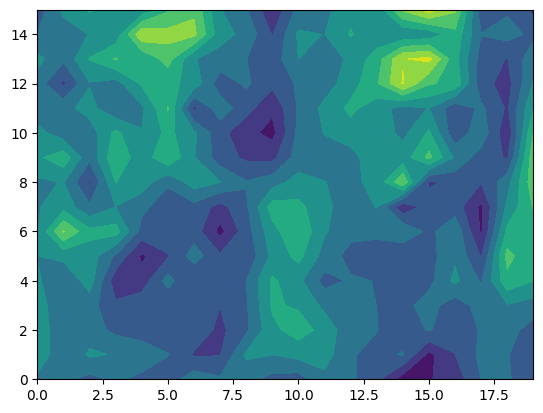

Range: -68.22041605123006 -> 100.26736029190128


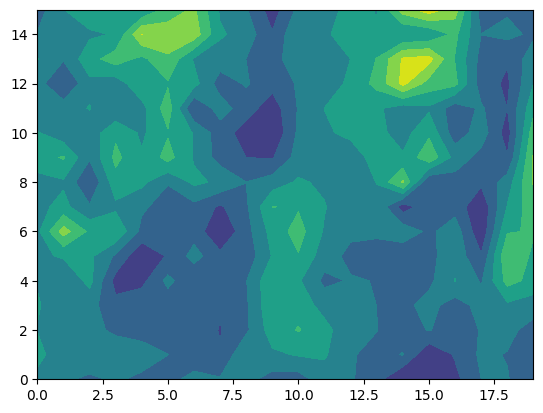

Range: -87.2442813237105 -> 127.29781317356407


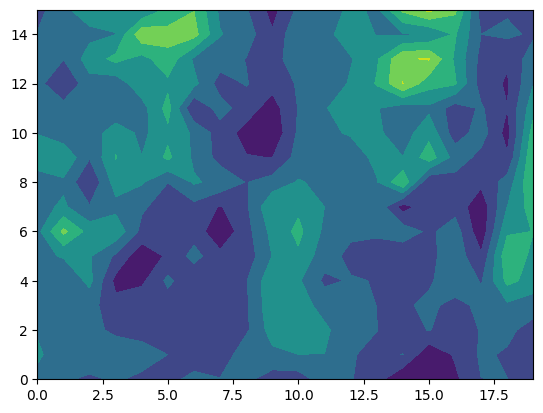

Range: -111.56772940082648 -> 161.61043506762672


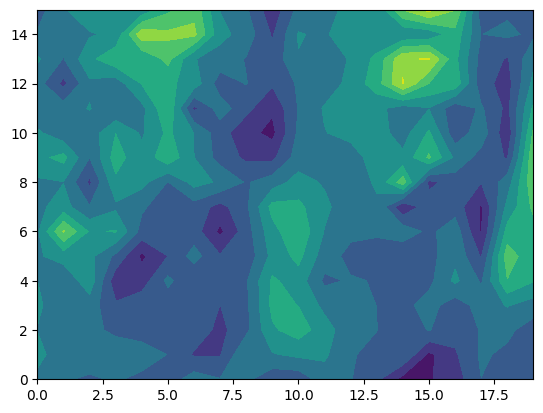

Range: -142.67169175940901 -> 205.1712670094429


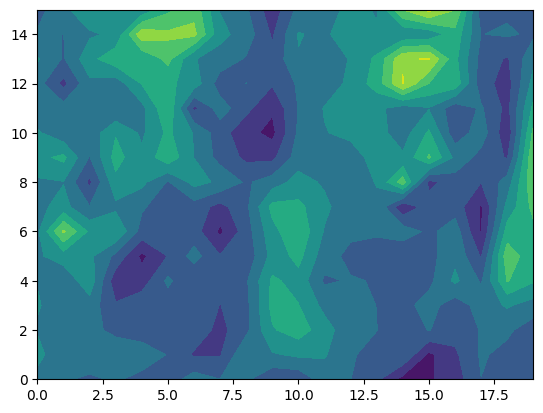

Range: -182.45209954223233 -> 260.47834640080026


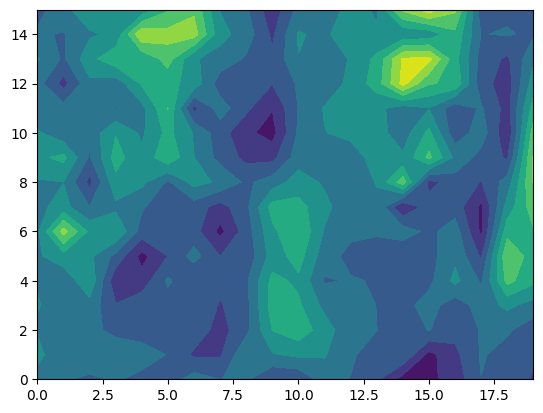

Range: -233.33652178333344 -> 330.70597259723263


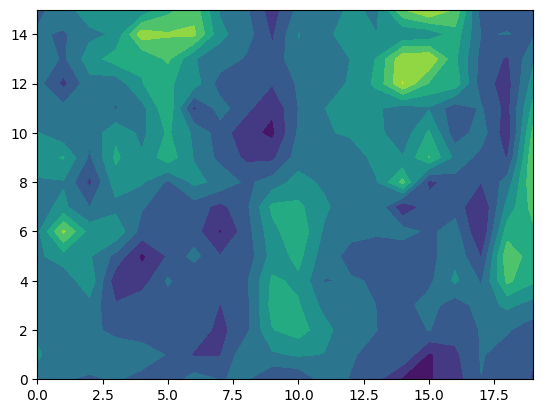

Range: -298.43367113188 -> 419.8881781389782


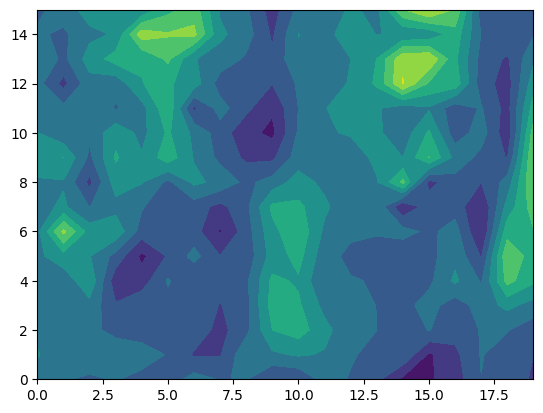

Range: -381.72506101610907 -> 533.1520816194724


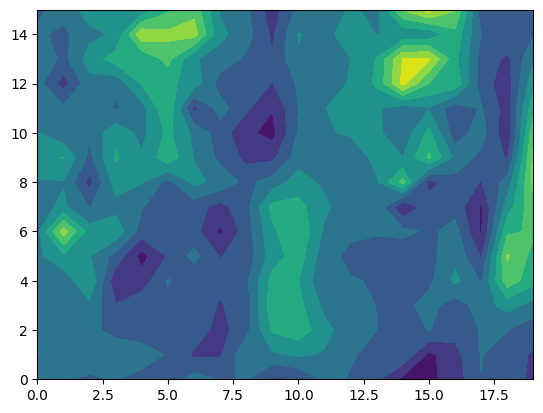

Range: -488.3107261863494 -> 677.0147109509909


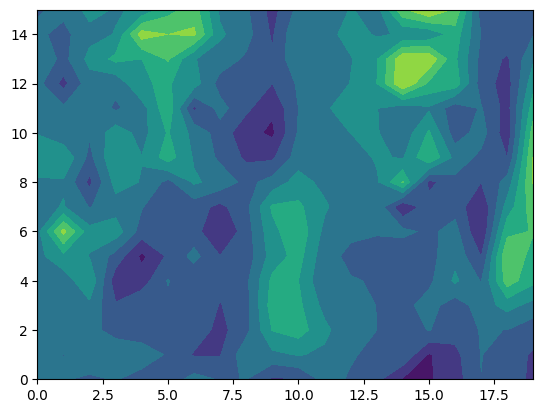

In [61]:
for i in range(10):
    # Take a step
    state = tf.linalg.lu_solve(lu, p, state)
    print(f"Range: {tf.math.reduce_min(state)} -> {tf.math.reduce_max(state)}")

    v = tf.gather(state, cell_number[2:-2,0,:])
    plt.contourf(v[:,:,0])
    plt.show()

In [44]:
state

<tf.Tensor: shape=(5120, 1), dtype=float64, numpy=
array([[0.85165771],
       [1.0828878 ],
       [0.76013453],
       ...,
       [1.03613696],
       [0.95904949],
       [1.68977492]])>

In [58]:
tf.gather(state, cell_number[2:-2,0,:])

<tf.Tensor: shape=(16, 20, 1), dtype=float64, numpy=
array([[[ 1.11385271],
        [ 1.10711728],
        [-0.59347041],
        [ 0.73219252],
        [ 0.17262547],
        [ 0.01082647],
        [ 1.4634992 ],
        [ 1.21197101],
        [ 1.98388714],
        [ 1.74372249],
        [ 1.33392842],
        [ 1.77876906],
        [ 1.6202854 ],
        [-0.08369839],
        [-1.8656999 ],
        [-1.17685125],
        [-0.77104702],
        [ 0.55284471],
        [ 1.00211628],
        [ 0.57415404]],

       [[ 2.95810472],
        [ 0.4188574 ],
        [ 2.30862205],
        [ 1.271786  ],
        [ 1.71304405],
        [ 0.91703784],
        [-0.4633219 ],
        [-0.04035284],
        [ 2.2138279 ],
        [ 1.25362744],
        [ 1.77784211],
        [ 2.62568085],
        [ 0.56697557],
        [ 0.19313331],
        [ 0.81740677],
        [-1.72063328],
        [ 0.35387249],
        [ 1.23837432],
        [ 1.24007723],
        [ 1.86573396]],

       [[ 2.57238203],


# Parallel diffusion

Solving diffusion equation, e.g. for temperature or scalar field $f$

$$
\frac{\partial f}{\partial t} = \nabla\cdot\left(K\mathbf{b}\mathbf{b}\cdot\nabla f\right)
$$

Antisymmetric form for positive-definite quantities:
$$
\frac{\partial \sqrt{f}^2}{\partial t} = \sqrt{f}\left(\nabla\cdot\mathbf{b}v_K + v_K\mathbf{b}\cdot\nabla\right)\sqrt{f}
$$

$$
v_K = 2K\mathbf{b}\cdot\nabla\left(\log\sqrt{f}\right)
$$

Publication: F.Halpern et al. "Parallel diffusion operator for magnetized plasmas with improved spectral fidelity" arXiv:2412.01927



## Staggered parallel gradient

Maps from cell centered quantity to its gradient at 1/2 step forward along the magnetic field

## Staggered parallel divergence

Maps from flows at 1/2 step forward to their divergence at cell centers. Derived from the staggered parallel gradient

## Parallel interpolation

Operators that interpolate between cell center and 1/2 step forward.



In [78]:
# Create a parallel gradient operator that maps from cell center quantities to staggered 1/2 way in the forward direction

grad_par_f = tf.sparse.add(forward_op,
                           tf.sparse.eye(n_evolving, num_columns=n_total, dtype=tf.dtypes.float64) * -1)

# Add rows for the radial (X) and parallel (Y) boundaries
# to create a square n_total x n_total matrix
grad_par_f = tf.sparse.SparseTensor(tf.concat([grad_par_f.indices,
                                                # X boundaries unchanged - ones on the diagonal
                                                tf.tile(boundary_xinner[:, 0][...,tf.newaxis], multiples=[1,2]),
                                                tf.tile(boundary_xouter[:, 0][...,tf.newaxis], multiples=[1,2]),
                                                # Y forward boundaries one-sided differences
                                                tf.tile(boundary_yforward[:, 0][...,tf.newaxis], multiples=[1,2]),
                                                boundary_yforward,
                                                # Y backward boundaries
                                                tf.tile(boundary_ybackward[:, 0][...,tf.newaxis], multiples=[1,2]),
                                                boundary_ybackward,
                                               ], axis = 0),
                                     tf.concat([grad_par_f.values,
                                                # X boundaries unchanged - ones on the diagonal
                                                tf.ones( boundary_xinner.shape[0] + boundary_xouter.shape[0], dtype=tf.dtypes.float64 ),
                                                # Y forward boundaries
                                                tf.ones( boundary_yforward.shape[0], dtype=tf.dtypes.float64 ),    # +1 in forward boundary cell
                                                tf.negative(tf.ones( boundary_yforward.shape[0], dtype=tf.dtypes.float64 )), # -1 in center cell
                                                # Y backward boundaries
                                                tf.negative(tf.ones( boundary_ybackward.shape[0], dtype=tf.dtypes.float64 )),  # -1 in boundary cell
                                                tf.ones( boundary_ybackward.shape[0], dtype=tf.dtypes.float64 ) # +1 in center cell
                                               ], axis = 0),
                                     [n_total, n_total])
grad_par_f = tf.sparse.reorder(grad_par_f) # Correctly sort indices

# Composing operators

To write equations like

$$
\frac{\partial v}{\partial t} = - \partial_{||} f
$$
$$
\frac{\partial f}{\partial t} = - \nabla_{||} v
$$

wrap the variables ($f$, $v$) in `Field` types, and the operators in `Operator` types 




In [36]:
class Field:
    def __init__(self, name, tensor=None):
        self.name = name
        self.tensor = tensor

    def __neg__(self):
        print("negate")

class Operator:
    def __init__(self, tensor):
        self.tensor = tensor
    
    def __call__(self, other):
        if not isinstance(other, Field):
            raise ValueError("Operators can only multiply Fields")
        return Field(other.name, tensor)




In [37]:
Grad_par = Operator(grad_par_op)
f = Field("f")
-Grad_par(f)

negate


In [72]:
help(tf.sparse.eye)

Help on function sparse_eye in module tensorflow.python.ops.sparse_ops:

sparse_eye(num_rows, num_columns=None, dtype=tf.float32, name=None)
    Creates a two-dimensional sparse tensor with ones along the diagonal.
    
    Args:
      num_rows: Non-negative integer or `int32` scalar `tensor` giving the number
        of rows in the resulting matrix.
      num_columns: Optional non-negative integer or `int32` scalar `tensor` giving
        the number of columns in the resulting matrix. Defaults to `num_rows`.
      dtype: The type of element in the resulting `Tensor`.
      name: A name for this `Op`. Defaults to "eye".
    
    Returns:
      A `SparseTensor` of shape [num_rows, num_columns] with ones along the
      diagonal.

